# Loading Packages and Data

In [1]:
import os
import shutil
import random

import numpy as np
import pandas as pd
import datetime
from packaging import version

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as k

In [2]:
# Set up notebook to display multiple outputs in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Designating File Paths

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#paths to the folders
galaxy_folder = '/content/drive/MyDrive/458_project_data/galaxy'
star_folder = '/content/drive/MyDrive/458_project_data/star'
combined_folder = '/content/drive/MyDrive/458_project_data/combined_data'

#make dir if it does not exist
os.makedirs(combined_folder, exist_ok=True)

## Combining the Data into one Folder + Adding Labels

In [7]:
galaxy_label = 0
star_label = 1

labels = []

#function to move files and label them
def move_and_label_images(source_folder, label, combined_folder):
  global labels
  images = os.listdir(source_folder)
  for img in images:
    shutil.copy(os.path.join(source_folder, img), combined_folder)
    labels.append(label)

move_and_label_images(galaxy_folder, galaxy_label, combined_folder)
move_and_label_images(star_folder, star_label, combined_folder)
labels = np.array(labels)

## Saving Image Paths

In [9]:
#list of image paths
image_paths = [os.path.join(combined_folder, img) for img in os.listdir(combined_folder)]

## Train, Test Split

In [10]:
# Loading in the data
x_train, x_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

len(x_train)
len(y_train)
len(x_test)
len(y_test)
print('\n')
np.count_nonzero(y_train == 0)
np.count_nonzero(y_train == 1)
np.count_nonzero(y_test == 0)
np.count_nonzero(y_test == 1)

1507

1507

377

377

754

753

188

189

## One Hot Encoding (for DNN)

In [11]:
# One hot encodeing
# One Hot encodeing for DNN experiments
y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)

y_test_enc[0:10,]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]])

## Loading and Normalizing Data

In [12]:
def load_and_normalize_images(image_paths):
  images = []
  for path in image_paths:
    img = tf.keras.preprocessing.image.load_img(path, target_size=(64, 64))
    #numpy array + standerdization
    img = tf.keras.preprocessing.image.img_to_array(img)
    #normalize the image
    img = img / 255.0
    images.append(img)
  return np.array(images)

x_train = load_and_normalize_images(x_train)
x_test = load_and_normalize_images(x_test)

x_train.shape
x_test.shape

(1507, 64, 64, 3)

(377, 64, 64, 3)

## Validation Split

In [13]:
# Seperating 10% validation set
x_val, x_train = x_train[:150], x_train[150:]
y_val, y_train = y_train[:150], y_train[150:]
y_val_enc, y_train_enc =  y_train_enc[:150], y_train_enc[150:]

x_train.shape
x_val.shape
y_train.shape
y_train_enc.shape
y_val.shape
y_val_enc.shape
x_test.shape

(1357, 64, 64, 3)

(150, 64, 64, 3)

(1357,)

(1357, 2)

(150,)

(150, 2)

(377, 64, 64, 3)

## Flattenning data (for DNN)

In [94]:
# Copy x data (DO NOT RERUN)
x_train_copy = x_train
x_test_copy = x_test
x_val_copy = x_val

In [97]:
#flatten
x_train = np.reshape(x_train, (1357, 4096*3))
x_test = np.reshape(x_test, (377, 4096*3))
x_val = np.reshape(x_val, (150, 4096*3))

x_train.shape
x_test.shape
x_val.shape

(1357, 12288)

(377, 12288)

(150, 12288)

In [96]:
#unflatten
x_train = x_train_copy
x_test = x_test_copy
x_val = x_val_copy

x_train.shape
x_test.shape
x_val.shape

(1357, 64, 64, 3)

(377, 64, 64, 3)

(150, 64, 64, 3)

1

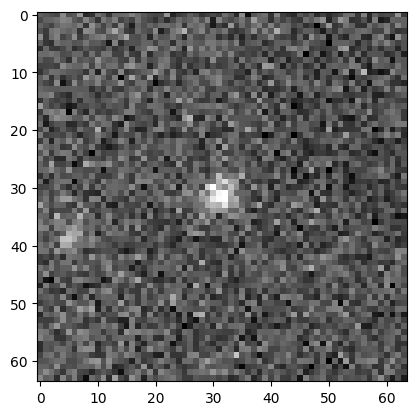

In [ ]:
# Visualizing some pictures. Will not work when x flattened
imagenumber=7
plt.imshow(x_train[imagenumber])
y_train[imagenumber]



# Defining Functions

In [14]:
def TrainingValidationLossAccPlot(model):
    # Plotting the performance metrics (loss)
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']
    loss = model.history['loss']
    val_loss = model.history['val_loss']

    epochs = range(1, len(acc)+1)
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plotting the performance metrics (accuracy)
    plt.clf()
    epochs = range(1, len(acc)+1)
    plt.plot(epochs, acc, label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [15]:
class_names = ['galaxy', 'star']
def PlotConfusionMatrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(4,3))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white', xticklabels=class_names, yticklabels=class_names)
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    return mtx


In [16]:
def BadPredImages(confusionmatrix, number):
    no_diag_conf_mx = np.where(np.eye(2, dtype=bool), 0, confusionmatrix)
    flattened = no_diag_conf_mx.flatten()
    sorted_indices = np.argsort(flattened)[-number:]
    max_values = flattened[sorted_indices][::-1]
    max_positions = [np.unravel_index(i, confusionmatrix.shape) for i in sorted_indices][::-1]
    #bad_pred = [(max_values[i], max_positions[i]) for i in range(len(max_values))]
    bad_pred_labels = [(max_values[i], (class_names[max_positions[i][0]], class_names[max_positions[i][1]])) for i in range(len(max_values))]
    return(bad_pred_labels)

In [17]:
def BadPredLabelNumbers(confusionmatrix, number):
    no_diag_conf_mx = np.where(np.eye(2, dtype=bool), 0, confusionmatrix)
    flattened = no_diag_conf_mx.flatten()
    sorted_indices = np.argsort(flattened)[-number:]
    max_values = flattened[sorted_indices][::-1]
    max_positions = [np.unravel_index(i, confusionmatrix.shape) for i in sorted_indices][::-1]
    bad_pred = [(max_values[i], max_positions[i]) for i in range(len(max_values))]
    return(bad_pred)

In [18]:
def PlotImages(rows, columns, images, title):
    fig, axes = plt.subplots(rows, columns, figsize=(15, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis('off')
    plt.suptitle(title)
    plt.show();

In [19]:
def PlotBadPredImages(rows, columns, badnumber, bad_pred_list):
    plt.figure(figsize=(rows, columns))
    X_ = x_test[(y_test.flatten()==bad_pred_list[badnumber][1][0]) & (pred_classes==bad_pred_list[badnumber][1][1])]
    if rows*columns > len(X_):
        raise ValueError(f'dimension error. too many rows/columns for the {len(X_)} images present in this misclassification')
    PlotImages(rows, columns, X_, f'True Label: {bad_pred_labels[badnumber][1][0]} Predicted Label: {bad_pred_labels[badnumber][1][1]}')

In [20]:
def PCAPixelReduction(percentage, xtrain, xval, xtest):
    # PCA reduction of pixels to % of data varience for model training
    pca = PCA(n_components=percentage)
    x_train_red = pca.fit_transform(xtrain)
    x_val_red = pca.transform(xval)
    x_test_red = pca.transform(xtest)

# Experiments

## Experiment 0

In [99]:
# model DNN with 1 hidden layer
k.clear_session()

experiment = 'Experiment 0'

activation1 = tf.keras.activations.relu
activation2=tf.keras.activations.softmax
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

layer1 = tf.keras.layers.Dense(units=500, activation=activation1, input_shape=(12288,))
layer2 = tf.keras.layers.Dense(units=2, activation=activation2)

model = tf.keras.Sequential()
model.add(layer1)
model.add(layer2)
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

model1 = model.fit(x_train, y_train_enc, epochs=30, validation_data=(x_val, y_val_enc))

Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.4960 - loss: 4.6530 - val_accuracy: 0.4600 - val_loss: 1.4575
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5139 - loss: 0.8989 - val_accuracy: 0.5667 - val_loss: 0.7231
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6154 - loss: 0.6375 - val_accuracy: 0.5467 - val_loss: 0.7914
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6639 - loss: 0.6111 - val_accuracy: 0.6000 - val_loss: 0.6807
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7263 - loss: 0.5343 - val_accuracy: 0.5800 - val_loss: 0.6995
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6349 - loss: 0.6366 - val_accuracy: 0.4600 - val_loss: 1.3052
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6635 - loss: 0.6426 - val_accuracy: 0.5467 - val_loss: 0.7328
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7698 - loss: 0.4983 - val_accuracy: 0.5333 - val_loss

In [ ]:
# Testing model on testing data
test_loss, test_acc = model.evaluate(x_test, y_test_enc)
#0.6350

## Experiment 1

DNN with 2 hidden layers (no regularization)

In [ ]:
k.clear_session()

experiment = 'Experiment 1'

activation1 = tf.keras.activations.relu
activation2=tf.keras.activations.softmax
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

layer1 = tf.keras.layers.Dense(units=128, activation=activation1, input_shape=(12288,))
layer2 = tf.keras.layers.Dense(units=100, activation=activation1)
layer3 = tf.keras.layers.Dense(units=2, activation=activation2)

model = tf.keras.Sequential()
model.add(layer1)
model.add(layer2)
model.add(layer3)
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

model1 = model.fit(x_train, y_train_enc, epochs=50, validation_data=(x_val, y_val_enc), callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.keras",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6),
                    ]
                   )

In [ ]:
# Testing model on testing data
test_loss, test_acc = model.evaluate(x_test, y_test_enc)
#.5382

## Experiment 2

DNN with 3 hidden layers

In [ ]:
k.clear_session()

experiment = 'Experiment 2'

activation1 = tf.keras.activations.relu
activation2=tf.keras.activations.softmax
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

layer1 = tf.keras.layers.Dense(units=128, activation=activation1, input_shape=(12288,))
layer2 = tf.keras.layers.Dense(units=100, activation=activation1)
layer3 = tf.keras.layers.Dense(units=100, activation=activation1)
layer4 = tf.keras.layers.Dense(units=2, activation=activation2)

model = tf.keras.Sequential()
model.add(layer1)
model.add(layer2)
model.add(layer3)
model.add(layer4)
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

model1 = model.fit(x_train, y_train_enc, epochs=50, validation_data=(x_val, y_val_enc), callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.keras",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6),
                    ]
                   )

In [ ]:
# Testing model on testing data
test_loss, test_acc = model.evaluate(x_test, y_test_enc)
#0.5438

## Experiment 3

 CNN with 2 convolution/max pooling layers (no regularization)

In [ ]:
# model
k.clear_session()

experiment = 'Experiment 3'

activation1 = tf.keras.activations.relu
activation2=tf.keras.activations.softmax
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam()

layer1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), strides=(1, 1), activation=activation1, input_shape=x_train.shape[1:])
pool1 = MaxPool2D((2, 2),strides=2)
layer2 = tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation=activation1)
pool2 = MaxPool2D((2, 2),strides=2)
layer3 = Flatten()
layer4 = tf.keras.layers.Dense(units=128, activation=activation2)
#norm = BatchNormalization()
layer5 = tf.keras.layers.Dense(units=2, activation=activation2)

model = tf.keras.Sequential()
model.add(layer1)
model.add(pool1)
model.add(layer2)
model.add(pool2)
model.add(layer3)
model.add(layer4)
#model.add(norm)
model.add(layer5)

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

model1 = model.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_val, y_val), callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.keras",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6),
                    ]
                   )

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 248ms/step - accuracy: 0.4947 - loss: 0.6939 - val_accuracy: 0.4733 - val_loss: 0.6927
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5108 - loss: 0.6913 - val_accuracy: 0.4933 - val_loss: 0.6878
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6535 - loss: 0.6611 - val_accuracy: 0.7800 - val_loss: 0.6268
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7350 - loss: 0.6204 - val_accuracy: 0.6867 - val_loss: 0.6348
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7139 - loss: 0.6081 - val_accuracy: 0.7400 - val_loss: 0.5892
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7867 - loss: 0.5634 - val_accuracy: 0.8133 - val_loss: 0.5451
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8045 - loss: 0.5453 - val_accuracy: 0.8333 - val_loss: 0.5192
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8530 - loss: 0.5102 - val_accuracy: 0.8467 -

In [ ]:
# Testing model on testing data
test_loss, test_acc = model.evaluate(x_test, y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.8549 - loss: 0.4320


## Experiment 4

CNN with 3 convolution/max pooling layers and batch normalization (no regularization)


In [84]:
# model
k.clear_session()

experiment = 'Experiment 4'

activation1 = tf.keras.activations.relu
activation2=tf.keras.activations.softmax
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam()

layer1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), strides=(1, 1), activation=activation1, input_shape=x_train.shape[1:])
pool1 = MaxPool2D((2, 2),strides=2)
layer2 = tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation=activation1)
pool2 = MaxPool2D((2, 2),strides=2)
layer3 = tf.keras.layers.Conv2D(filters=512, kernel_size=(4, 4), strides=(1, 1), activation=activation1)
pool3 = MaxPool2D((2, 2),strides=2)
layer4 = Flatten()
layer5 = tf.keras.layers.Dense(units=128, activation=activation2)
norm = BatchNormalization()
layer6 = tf.keras.layers.Dense(units=2, activation=activation2)

model = tf.keras.Sequential()
model.add(layer1)
model.add(pool1)
model.add(layer2)
model.add(pool2)
model.add(layer3)
model.add(pool3)
model.add(layer4)
model.add(layer5)
model.add(norm)
model.add(layer6)

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

model1 = model.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_val, y_val), callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.keras",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6),
                    ]
                   )

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step - accuracy: 0.6459 - loss: 0.6409 - val_accuracy: 0.8467 - val_loss: 0.6674
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8066 - loss: 0.4298 - val_accuracy: 0.6533 - val_loss: 0.6551
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8594 - loss: 0.3531 - val_accuracy: 0.7533 - val_loss: 0.6433
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8553 - loss: 0.3653 - val_accuracy: 0.7400 - val_loss: 0.6321
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8832 - loss: 0.2888 - val_accuracy: 0.8933 - val_loss: 0.6265
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8901 - loss: 0.2680 - val_accuracy: 0.6600 - val_loss: 0.6241
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9252 - loss: 0.2153 - val_accuracy: 0.7867 - val_loss: 0.5894
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9487 - loss: 0.1677 - val_accuracy: 0.7867 - 

In [85]:
# Testing model on testing data
test_loss, test_acc = model.evaluate(x_test, y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.8019 - loss: 0.4863


## Experiment 5&6

 CNN with 3 convolution/max pooling layers with dropout layers and L2(0.001) regularizer

In [81]:
# model
k.clear_session()

experiment = 'Experiment 10'

activation1 = tf.keras.activations.relu
activation2=tf.keras.activations.softmax
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam()

layer1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=activation1, input_shape=x_train.shape[1:])
pool1 = MaxPool2D((2, 2),strides=2)
drop1 = Dropout(0.3)
layer2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=activation1)
pool2 = MaxPool2D((2, 2),strides=2)
drop2 = Dropout(0.3)
layer3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=activation1)
pool3 = MaxPool2D((2, 2),strides=2)
drop3 = Dropout(0.3)
layer4 = Flatten()
layer5 = tf.keras.layers.Dense(units=300, activation=activation2, kernel_regularizer=tf.keras.regularizers.L2(0.001))
norm = BatchNormalization()
drop5 = Dropout(0.3)
layer6 = tf.keras.layers.Dense(units=2, activation=activation2)

model = tf.keras.Sequential()
model.add(layer1)
model.add(pool1)
model.add(drop1)
model.add(layer2)
model.add(pool2)
model.add(drop2)
model.add(layer3)
model.add(pool3)
model.add(drop3)
model.add(layer4)
model.add(layer5)
model.add(norm)
model.add(drop5)
model.add(layer6)
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

model1 = model.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_val, y_val), callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.keras",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6),
                    ]
                   )

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 280ms/step - accuracy: 0.5049 - loss: 1.1206 - val_accuracy: 0.4667 - val_loss: 0.8672
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5894 - loss: 0.8207 - val_accuracy: 0.4600 - val_loss: 0.7872
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6319 - loss: 0.7424 - val_accuracy: 0.6800 - val_loss: 0.7611
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6701 - loss: 0.6833 - val_accuracy: 0.5000 - val_loss: 0.7421
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7582 - loss: 0.5874 - val_accuracy: 0.6800 - val_loss: 0.7267
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8040 - loss: 0.5043 - val_accuracy: 0.5933 - val_loss: 0.7015
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8217 - loss: 0.4645 - val_accuracy: 0.6800 - val_loss: 0.7070
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8161 - loss: 0.4712 - val_accuracy: 0.6933 -

In [82]:
# Testing model on testing data
test_loss, test_acc = model.evaluate(x_test, y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.8556 - loss: 0.5056


In [84]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 31, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 300)                 │       1,382,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 300)                 │           1,200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             602 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,048,564 (19.26 MB)

 Trainable params: 1,682,654 (6.42 MB)

 Non-trainable params: 600 (2.34 KB)

 Optimizer params: 3,365,310 (12.84 MB)

# Model Visualizations

Experiment 10


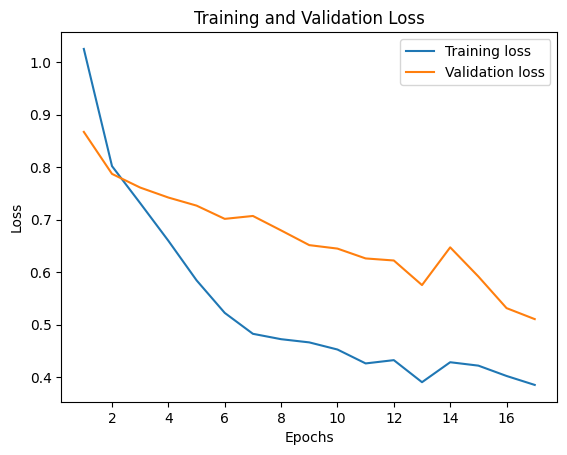

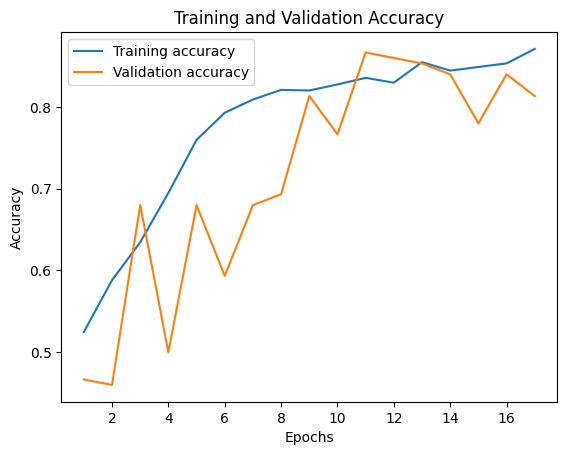

In [83]:
# Traingin and Validation Loss and Accuracy performance plots
print(f'{experiment}')
TrainingValidationLossAccPlot(model1)

In [85]:
# Confusion Matrix
print(f'{experiment}')
pred_classes = np.argmax(model.predict(x_test), axis=-1) #switch this variable to x_test_norm for Experiments 1 through 3, and switch to x_test_red for Experiment 4, and test_images_sm for Experiment 5
pred_classes

Experiment 10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


array([1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,

Experiment 10


array([[152,  36],
       [ 22, 167]])

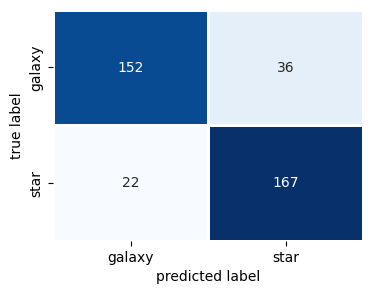

In [86]:
print(f'{experiment}')
conf_mx = PlotConfusionMatrix(y_test, pred_classes)
conf_mx

In [87]:
# Looking at the bad prediction numbers
print(f'{experiment}')
bad_pred_labels = BadPredImages(conf_mx, 2)
bad_pred_label_numbers = BadPredLabelNumbers(conf_mx, 2)
bad_pred_labels

Experiment 10


[(36, ('galaxy', 'star')), (22, ('star', 'galaxy'))]

<Figure size 300x500 with 0 Axes>

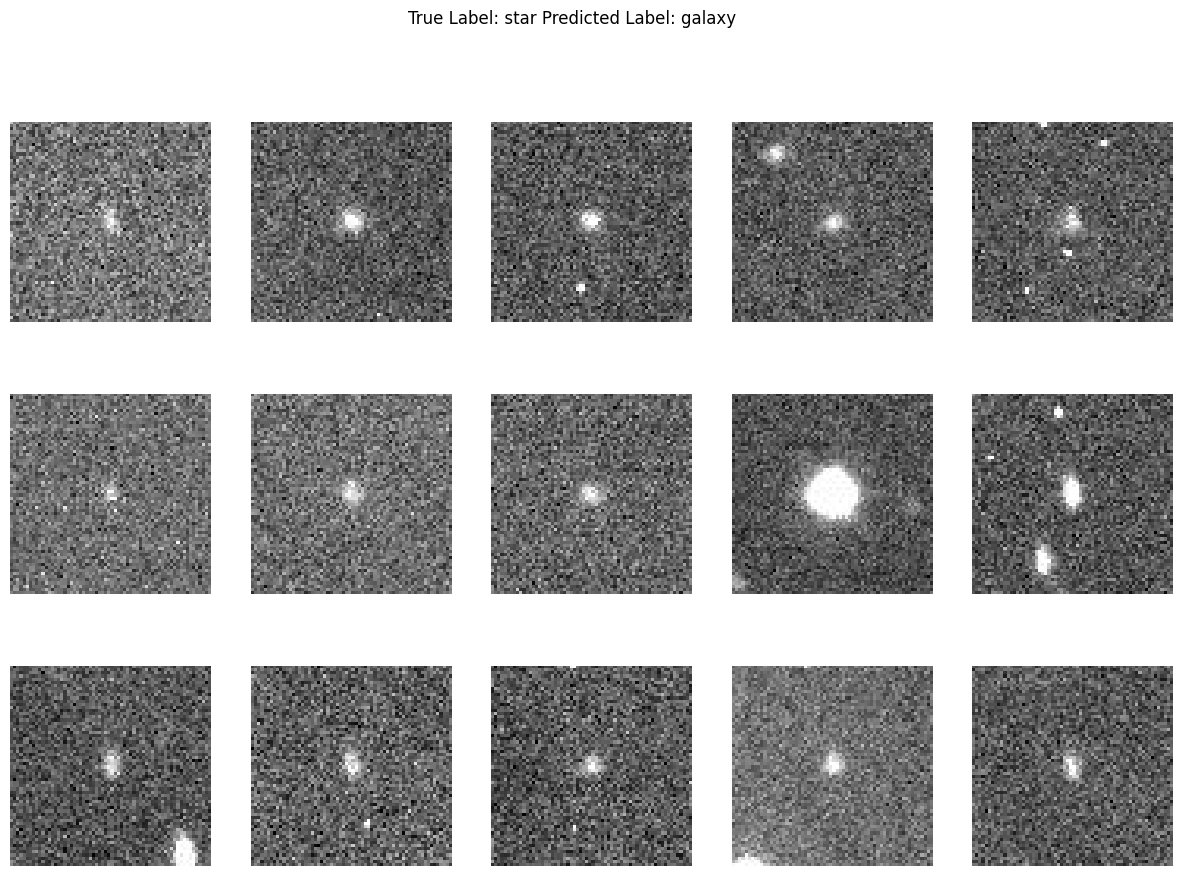

In [93]:
# does not work when x is flattened
PlotBadPredImages(3, 5, 1, bad_pred_label_numbers)

In [ ]:
ex3df = pd.DataFrame({'Training Accuracy':[43.11, 70.32, 97.16, 99.49, 99.85, 99.79, 99.95, 99.86],
                     'Validation Accuracy':[45.14, 71.66, 95.42,  96.92, 97.54, 97.88, 98.22, 98.22],
                     'Testing Accuracy':[42.48, 68.80, 95.01, 96.36, 97.03, 97.43, 97.80, 97.93],
                     'Number of Nodes':[1, 2, 16, 32, 64, 128, 256, 512]})


plt.figure(figsize=(10, 6))
plt.plot(ex3df['Number of Nodes'], ex3df['Training Accuracy'], label='Training Accuracy', marker='o')
plt.plot(ex3df['Number of Nodes'], ex3df['Validation Accuracy'], label='Validation Accuracy', marker='o')
plt.plot(ex3df['Number of Nodes'], ex3df['Testing Accuracy'], label='Testing Accuracy', marker='o')

plt.xlabel('Number of Nodes')
plt.ylabel('Accuracy %')
plt.title('Model Training, Validation and Testing Accuracy vs Number of Nodes')
plt.legend()
plt.grid(True);

# Feature Extraction

Experiment 10


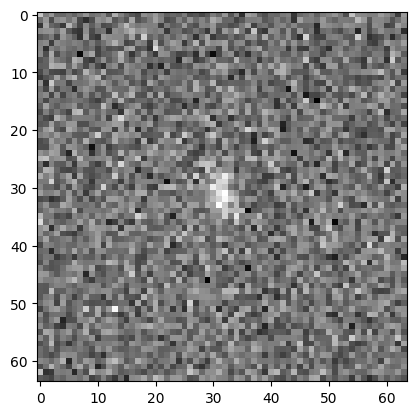

In [89]:
# galaxy classified as a star
print(f'{experiment}')
X_db = x_test[(y_test.flatten()==1) & (pred_classes==0)]
plt.imshow(X_db[0])

Experiment 4


(-0.5, 63.5, 63.5, -0.5)

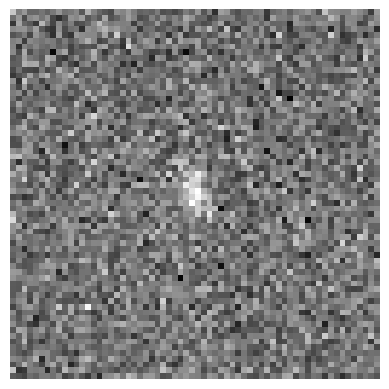

In [77]:
print(f'{experiment}')

img = X_db[0]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [78]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:4]]
# Creates a model that will return these outputs, given the model input:
activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer_outputs)

In [79]:
activations = activation_model.predict(img_tensor)
len(activations)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


4

<ipython-input-80-39251548b61f>:27: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
<ipython-input-80-39251548b61f>:30: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


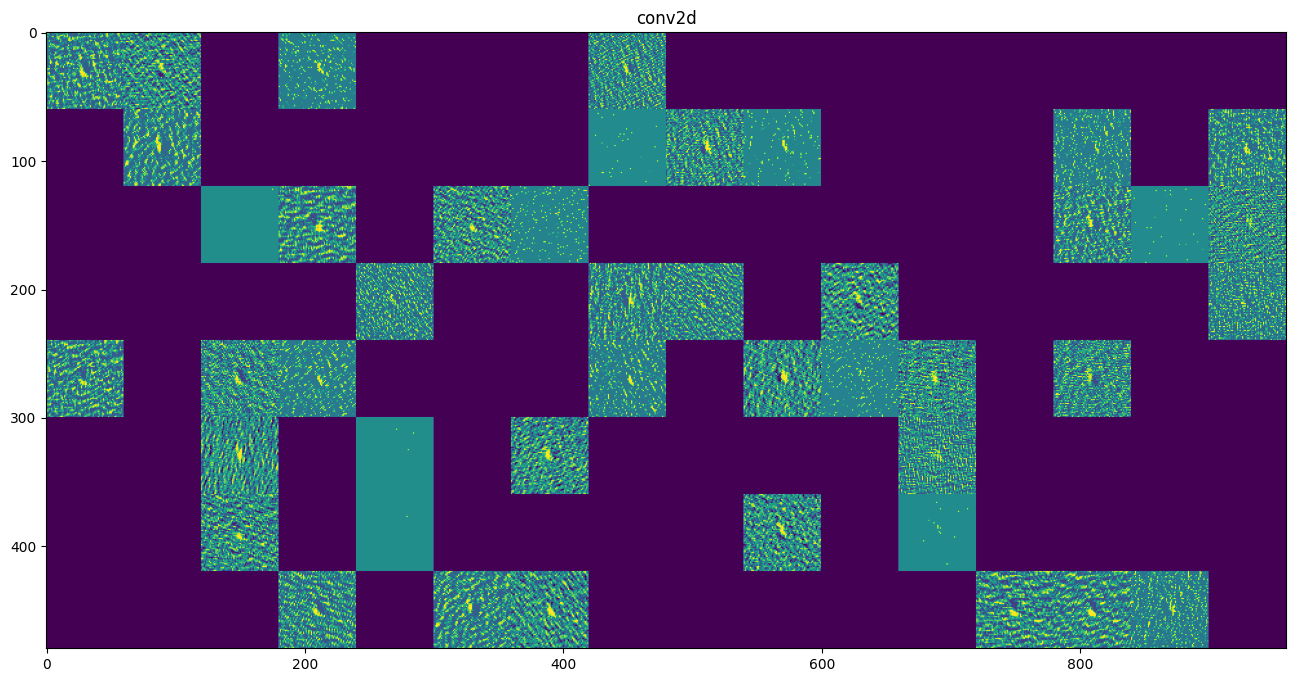

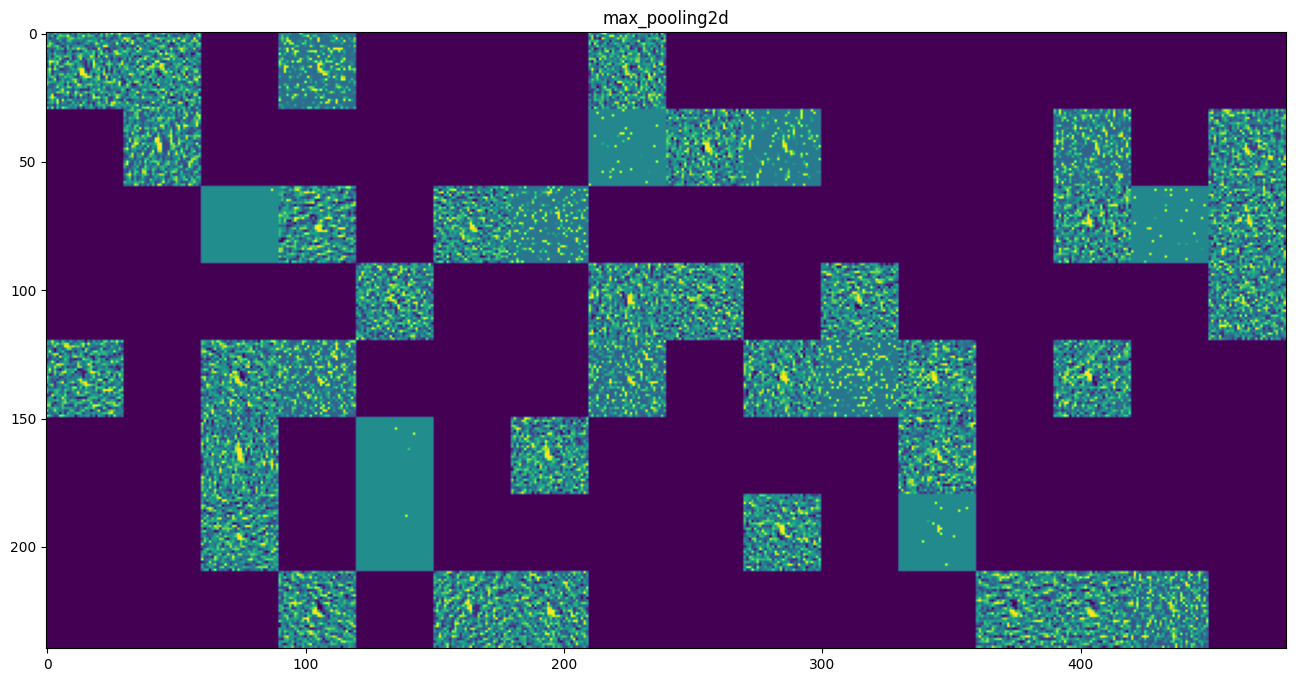

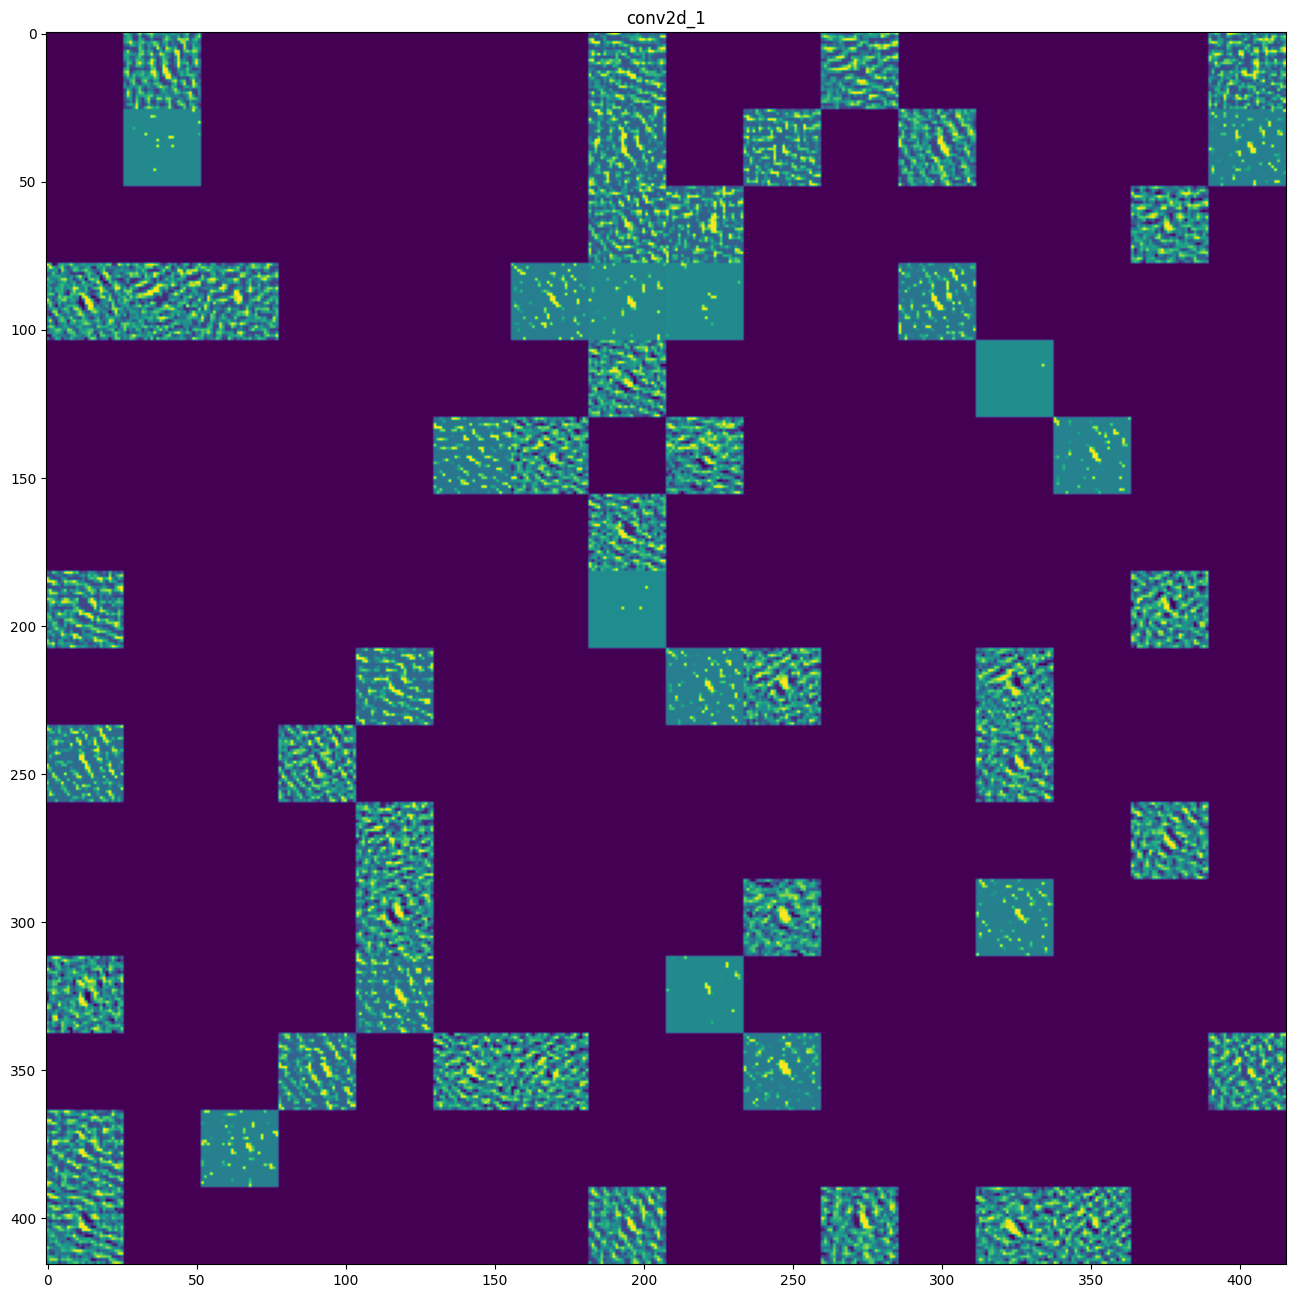

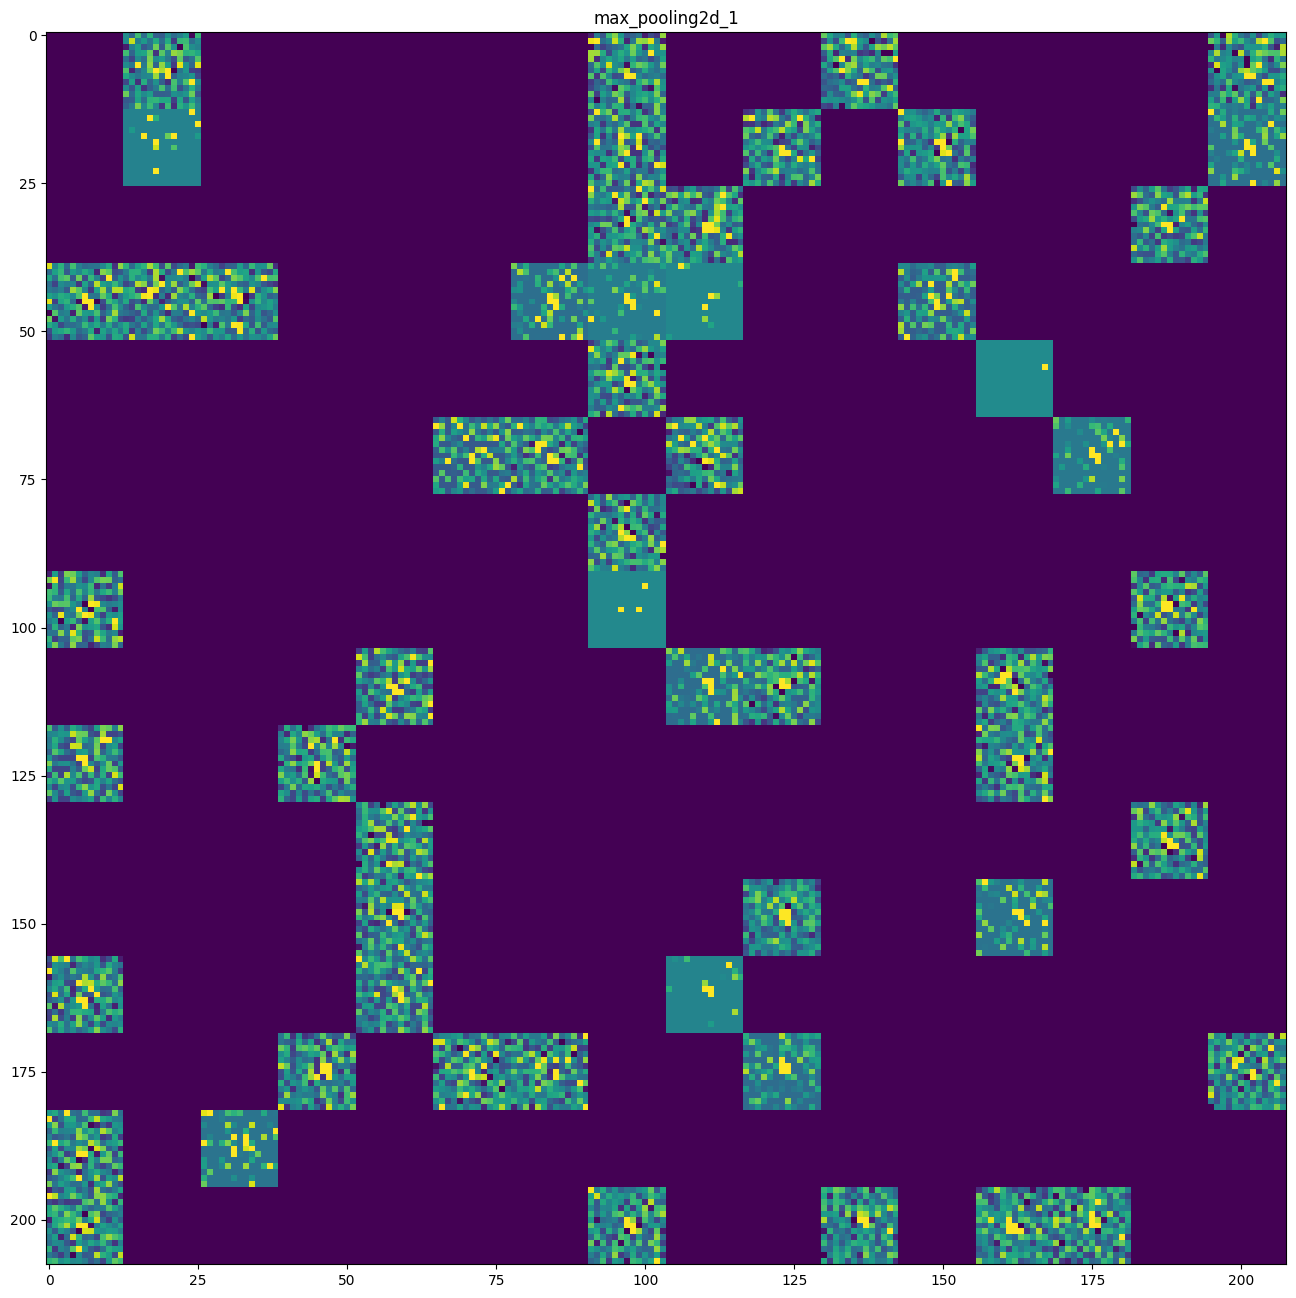

In [80]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show();

# Model Classification Probabilities

In [ ]:
model = tf.keras.models.load_model('CNN_model.keras')

In [ ]:
model.build(input_shape=(None, 64, 64, 3))

In [ ]:
preds = model.predict(x_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


In [ ]:
preds.shape

(377, 2)

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:20], columns = ['star', 'galaxy'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,star,galaxy
0,24.63%,75.37%
1,23.82%,76.18%
2,75.04%,24.96%
3,61.15%,38.85%
4,69.15%,30.85%
5,75.80%,24.20%
6,33.31%,66.69%
7,66.92%,33.08%
8,75.64%,24.36%
9,23.79%,76.21%
